# HW03
Deep Learning, GIST RT5101-01, 2024, Spring, (Tue/Thurs 2:30~3:45)
***

### Problem1. Build cat and dog detection dataset code
(Download URL: https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection)
- Build detection dataset code
- Check your dataset code
----

### Problem2. Train cat and dog detection data using FasterRCNN
- Training detection dataset
- Check the result
- Analysis your result

***
### You can add additional code for checking your image and model.
### You must summit ``.ipynb`` file. Do not summit ``.py`` file.
---

### How to submit your homework
Submit your jupyter notebook file with the filename of  *HW03_studentnumber.ipynb*  on GIST LMS

Ex) HW03_20222015.ipynb  

### Submission deadline
2024.06.16, Sunday 23:59 (PM)

### Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.




***
***

In [ ]:
# mount your google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Problem 1. (total 5 pt.)
**Build cat and dog detection dataset code**

- **1**. Build dataset code
- **2**. Split into train dataset and test dataset.
- **3**. Check your dataset code

### Problem 1-1. (2 pt.)
Build dataset code

In [19]:
import os
from bs4 import BeautifulSoup

# This is a reference code for reading an XML file.
# Utilize this code to read an annotation file to extract bbox information.

def read_ann(directory):
    annotations = os.listdir(directory)

    records = []
    for annot_file in annotations:
        with open(os.path.join(directory,annot_file), 'r') as f:
            file = f.read()

        data = BeautifulSoup(file, "xml")

        objects = data.find_all('object')
        length = len(objects)
        filename = data.find("filename").text
        # img_width = int(data.find('size').width.text)
        # img_height = int(data.find('size').height.text)

        for i in range(length):
            class_name = data.find_all('object')[i].find('name').text
            xmin = int(data.find_all('object')[i].find('bndbox').find('xmin').text)#/img_width
            ymin = int(data.find_all('object')[i].find('bndbox').find('ymin').text)#/img_height
            xmax = int(data.find_all('object')[i].find('bndbox').find('xmax').text)#/img_width
            ymax = int(data.find_all('object')[i].find('bndbox').find('ymax').text)#/img_height

            records.append([filename,class_name,xmin,ymin,xmax,ymax])
    return records

In [21]:
import os
import numpy as np
import torch
from PIL import Image

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = sorted(os.listdir(os.path.join(root, './data/images')))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

### Problem 1-2. (2 pt.)
Split into train dataset and test dataset.


In [ ]:
batch_size =32

In [ ]:
import sys
### Change to your own path
sys.path.append('')

import transforms as T

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
# used for padding variable-length batches.
# "*" = splat operator : unpacking a list into arguments

In [ ]:
def get_transform():
  transforms = T.Compose([
    transforms.Resize((128, 128)),
    T.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  return transforms

In [ ]:
data_loader =
data_loader_test =

In [ ]:
# Check dataset loader's return
for i, (img, target) in enumerate(data_loader):
  for j in range(batch_size):
    print('SIze of image : (C, H, W) ',img[j].shape)
    print('Number of the objects :', len(target[j]['boxes']))
  if i> 3:
    break

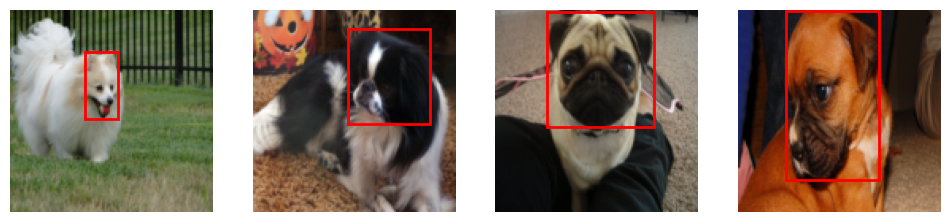

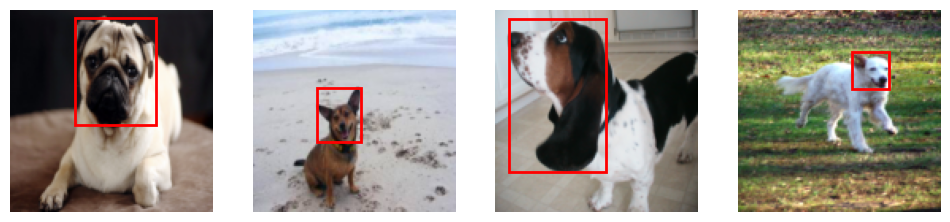

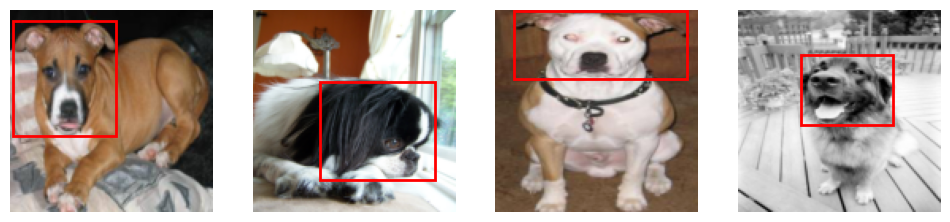

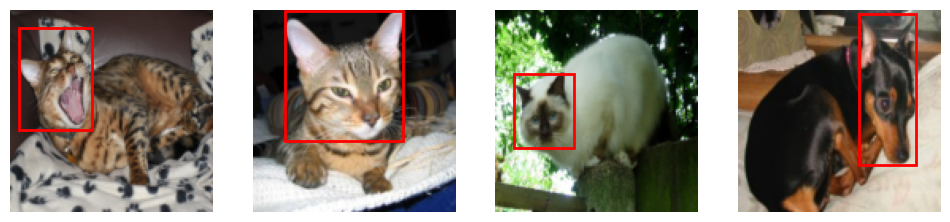

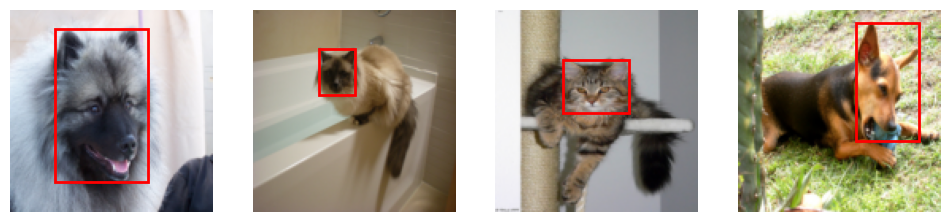

In [27]:
import os
from bs4 import BeautifulSoup
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

# Custom dataset class
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        original_w, original_h = annots[0][6], annots[0][7]
        for annot in annots:
            xmin = annot[2] * 128 / original_w
            ymin = annot[3] * 128 / original_h
            xmax = annot[4] * 128 / original_w
            ymax = annot[5] * 128 / original_h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Transformation function
def get_transform():
    return T.Compose([
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Load annotations
annotations = read_ann('./data/annotations')

# Initialize dataset and dataloader
dataset = CatDogDataset('./data', annotations, transforms=get_transform())
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Visualization function
def visualize_data(loader, batch_size):
    for i, (imgs, targets) in enumerate(loader):
        fig, axs = plt.subplots(1, batch_size, figsize=(batch_size*3, 3))
        for j in range(batch_size):
            img = imgs[j].permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[j].imshow(img)
            for box in targets[j]['boxes']:
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                axs[j].add_patch(rect)
            axs[j].axis('off')
        plt.show()
        if i > 3:
            break

# Visualize some data
visualize_data(data_loader, batch_size=4)


### Problem 1-3. (1 pt.)
Check your dataset code

In [ ]:
# visualize train image

In [ ]:
# visualize train image's bbox

---
---

## Problem 2. (Total 5 pt.)
- **Train Dogs and Cats data using FasterRCNN**


### Problem 2-1. (3 pt.)
- **Step 1**. Import package.
- **Step 2**. Build your FasterRCNN model.
- **Step 3**. Define hyper-parameter for training
- **Step 4**. Train the model and check the validation results  

In [ ]:
''' Step 1 '''
# Import package.

In [ ]:
import sys
### Change to your own path
sys.path.append('/content/drive/MyDrive/2024_deep_learning/coding_lecture/04.04.CodingLecture05/vis_utils')

import utils
from engine import *
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

In [ ]:
''' Step 2 '''
# Build your FasterRCNN model.

model =

# change classififer class size


In [ ]:
''' Step 3 '''
# Define hyper-parameter for training.

params =

optimizer =

lr_scheduler =

num_epochs =

In [ ]:
''' Step 4 '''
# Train the model and check the validation results

In [ ]:
# define model training function

In [ ]:
# model training
for epoch in range(num_epochs):

In [ ]:
# define model evaluate function

In [ ]:
# run evaluate code

In [28]:
import os
from bs4 import BeautifulSoup
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

# Custom dataset class
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        original_w, original_h = annots[0][6], annots[0][7]
        for annot in annots:
            xmin = annot[2] * 128 / original_w
            ymin = annot[3] * 128 / original_h
            xmax = annot[4] * 128 / original_w
            ymax = annot[5] * 128 / original_h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Transformation function
def get_transform(train):
    transforms = []
    transforms.append(T.Resize((128, 128)))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Load annotations
annotations = read_ann('./data/annotations')

# Initialize dataset and dataloader
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Define the model
def get_model(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Model instance
model = get_model(num_classes=2)  # 2 classes (background and cat/dog)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if epoch % print_freq == 0:
            print(f"Epoch: {epoch}, Loss: {losses.item()}")

# Evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images, targets)
            # Implement evaluation metrics if needed
            # For now, just ensure the model runs without errors

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save the model
torch.save(model.state_dict(), 'faster_rcnn_cat_dog.pth')

# Visualization function to see predictions
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            outputs = model(images)
        
        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            for box in outputs[i]['boxes']:
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)


c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch

Epoch: 0, Loss: 1.1741020679473877
Epoch: 0, Loss: 0.33845436573028564
Epoch: 0, Loss: 0.30998745560646057
Epoch: 0, Loss: 0.3716631829738617
Epoch: 0, Loss: 0.3364773690700531
Epoch: 0, Loss: 0.27081096172332764
Epoch: 0, Loss: 0.20853857696056366
Epoch: 0, Loss: 0.19796693325042725
Epoch: 0, Loss: 0.27387431263923645
Epoch: 0, Loss: 0.25656357407569885
Epoch: 0, Loss: 0.23400230705738068
Epoch: 0, Loss: 0.23224128782749176
Epoch: 0, Loss: 0.2259591519832611
Epoch: 0, Loss: 0.20535768568515778
Epoch: 0, Loss: 0.21111935377120972
Epoch: 0, Loss: 0.1644899696111679
Epoch: 0, Loss: 0.21415209770202637
Epoch: 0, Loss: 0.1719265729188919
Epoch: 0, Loss: 0.20663495361804962
Epoch: 0, Loss: 0.22052285075187683
Epoch: 0, Loss: 0.21554526686668396
Epoch: 0, Loss: 0.18920333683490753
Epoch: 0, Loss: 0.17273369431495667
Epoch: 0, Loss: 0.21994037926197052
Epoch: 0, Loss: 0.2258787602186203
Epoch: 0, Loss: 0.20802056789398193
Epoch: 0, Loss: 0.20811106264591217
Epoch: 0, Loss: 0.2097824364900589


KeyboardInterrupt: 

In [29]:
# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Load annotations
annotations = read_ann('./data/annotations')

# Initialize dataset and dataloader
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Define the model
def get_model(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Model instance
model = get_model(num_classes=2)  # 2 classes (background and cat/dog)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if epoch % print_freq == 0:
            print(f"Epoch: {epoch}, Loss: {losses.item()}")

# Evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images, targets)
            # Implement evaluation metrics if needed
            # For now, just ensure the model runs without errors

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save the model
torch.save(model.state_dict(), 'faster_rcnn_cat_dog.pth')

# Visualization function to see predictions
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            outputs = model(images)
        
        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            for box in outputs[i]['boxes']:
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)

Epoch: 0, Loss: 1.0681394338607788
Epoch: 0, Loss: 0.2597000002861023
Epoch: 0, Loss: 0.2508954107761383
Epoch: 0, Loss: 0.18667709827423096
Epoch: 0, Loss: 0.24469533562660217
Epoch: 0, Loss: 0.42343631386756897
Epoch: 0, Loss: 0.29293012619018555
Epoch: 0, Loss: 0.1974850744009018
Epoch: 0, Loss: 0.21945679187774658
Epoch: 0, Loss: 0.23144109547138214
Epoch: 0, Loss: 0.23374781012535095
Epoch: 0, Loss: 0.22814851999282837
Epoch: 0, Loss: 0.19908243417739868
Epoch: 0, Loss: 0.2304561287164688
Epoch: 0, Loss: 0.21600039303302765
Epoch: 0, Loss: 0.20187057554721832
Epoch: 0, Loss: 0.2406509667634964
Epoch: 0, Loss: 0.23991942405700684
Epoch: 0, Loss: 0.19288936257362366
Epoch: 0, Loss: 0.260010689496994
Epoch: 0, Loss: 0.24881760776042938
Epoch: 0, Loss: 0.12274687737226486
Epoch: 0, Loss: 0.20560318231582642
Epoch: 0, Loss: 0.17882008850574493
Epoch: 0, Loss: 0.22369839251041412
Epoch: 0, Loss: 0.2061976194381714
Epoch: 0, Loss: 0.20189499855041504
Epoch: 0, Loss: 0.2408473789691925
Ep

KeyboardInterrupt: 

### Problem 2-2. (2 pt.)
Analysis your result

In [ ]:
import cv2
def overlay_instances(img, prediction, threshold=0.8):
    label_dict = {0: 'cat', 1: 'dog'}
    ori_img = img.mul(255).permute(1,2,0).byte().numpy() # Tensor * 255, Convert RGB -> BGR, Tensor to numpy
    for idx in range(len(prediction[0]['boxes'])):
        score = prediction[0]['scores'][idx].cpu().detach().numpy().item() # detach() : Generation of tensors that do not propagate gradients from existing sensors
        if score < threshold:
            continue
        box = x1,y1,x2,y2 = prediction[0]['boxes'][idx].cpu().detach().numpy()
        label = prediction[0]['labels'][idx].cpu().detach().numpy().item()
        print(x1,y1, x2, y2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x1+60), int(y1+20)), (255,0,0),-1)
        cv2.putText(ori_img, label_dict[label], (int(x1), int(y1+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness=1)
    return Image.fromarray(ori_img)

In [ ]:
# Inference on test images

#### Your Anwser :

In [11]:
import os
from bs4 import BeautifulSoup

def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "lxml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').xmin.text)
            ymin = int(obj.find('bndbox').ymin.text)
            xmax = int(obj.find('bndbox').xmax.text)
            ymax = int(obj.find('bndbox').ymax.text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax])
    
    return records

# 예시 사용법
annotations_dir = './data/annotations'  # 실제 annotations 폴더 경로
records = read_ann(annotations_dir)
print(records)


[['Cats_Test0.png', 'cat', 83, 29, 197, 142], ['Cats_Test1.png', 'dog', 128, 22, 240, 222], ['Cats_Test10.png', 'dog', 157, 56, 264, 116], ['Cats_Test100.png', 'cat', 142, 145, 206, 209], ['Cats_Test1000.png', 'cat', 36, 14, 289, 312], ['Cats_Test1001.png', 'dog', 140, 80, 229, 152], ['Cats_Test1002.png', 'cat', 178, 107, 294, 223], ['Cats_Test1003.png', 'dog', 148, 39, 355, 244], ['Cats_Test1004.png', 'dog', 53, 27, 239, 121], ['Cats_Test1005.png', 'cat', 65, 16, 294, 221], ['Cats_Test1006.png', 'dog', 95, 20, 299, 290], ['Cats_Test1007.png', 'cat', 225, 52, 381, 195], ['Cats_Test1008.png', 'cat', 108, 149, 199, 229], ['Cats_Test1009.png', 'dog', 70, 48, 168, 120], ['Cats_Test101.png', 'cat', 134, 79, 297, 234], ['Cats_Test1010.png', 'cat', 36, 65, 137, 172], ['Cats_Test1011.png', 'cat', 112, 64, 217, 164], ['Cats_Test1012.png', 'dog', 94, 36, 378, 263], ['Cats_Test1013.png', 'dog', 130, 38, 237, 132], ['Cats_Test1014.png', 'cat', 195, 61, 374, 177], ['Cats_Test1015.png', 'dog', 94, 3

In [12]:
import torch
from PIL import Image

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotations, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations = annotations
        self.imgs = sorted(os.listdir(os.path.join(root, './data/images')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, './data/images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        annots = [annot for annot in self.annotations if annot[0] == self.imgs[idx]]
        boxes = []
        labels = []
        for annot in annots:
            xmin, ymin, xmax, ymax = annot[2], annot[3], annot[4], annot[5]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1 if annot[1] == 'dog' else 0)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target

# 예시 사용법
dataset_dir = '.'  # 실제 dataset 폴더 경로 (현재 작업 디렉토리)
annotations_dir = './data/annotations'
annotations = read_ann(annotations_dir)
dataset = CatDogDataset(root=dataset_dir, annotations=annotations)

# 학습 및 테스트 데이터로 분리
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)


In [14]:
from torchvision import transforms as T
def get_transform():
    return T.Compose([T.ToTensor()])

transforms = get_transform()
dataset = CatDogDataset(root=dataset_dir, annotations=annotations, transforms=transforms)


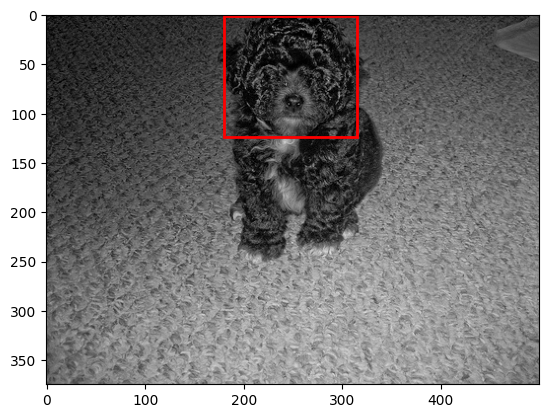

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(img, target):
    img = np.array(img)
    plt.imshow(img)
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
    plt.show()

# 예시 사용법
img, target = train_dataset[0]
visualize_sample(img, target)


Faster RNN

In [ ]:
import cv2

def overlay_instances(img, prediction, threshold=0.8):
    label_dict = {0: 'background', 1: 'cat', 2: 'dog'}
    ori_img = img.mul(255).permute(1,2,0).byte().numpy()
    for idx in range(len(prediction['boxes'])):
        score = prediction['scores'][idx].cpu().detach().numpy().item()
        if score < threshold:
            continue
        box = x1, y1, x2, y2 = prediction['boxes'][idx].cpu().detach().numpy()
        label = prediction['labels'][idx].cpu().detach().numpy().item()
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x1+60), int(y1+20)), (255,0,0),-1)
        cv2.putText(ori_img, label_dict[label], (int(x1), int(y1+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness=1)
    return Image.fromarray(ori_img)

# 예시 사용법
model.eval()
img, target = test_dataset[0]
with torch.no_grad():
    prediction = model([img.to(device)])[0]
overlayed_img = overlay_instances(img, prediction)
overlayed_img.show()
